# Baseline - Training on Source Only

This is the baseline to compare against other unsupervised domain adaptation approaches. In this notebook, we train a model on only the source domain and evaluate its performance on the target domain. In addition, we also train a model directly on the target domain to obtain an upper-bound on the performance of the model after domain adaptation.

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import _base_model
import _dataloader_helper

#### For logging multiple runs

In [3]:
import pathlib

log_root = pathlib.Path(f'./baseline')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
print(f'Logging to: {log_dir}')

Logging to: baseline\run2


### Prepare dataset

Here, we transform both the source and target datasets into the same size, and repeat the channel dimension for grayscale images, such that both datasets have the same input shape to the model.

In [4]:
input_shape = (3, 32, 32)
num_classes = 10

loader_helper = _dataloader_helper.MNIST2USPS(image_size=input_shape[1:])
src_train, src_val, src_test = loader_helper.get_src_loaders()
tgt_train, tgt_val, tgt_test = loader_helper.get_tgt_loaders()

#### Visualize some samples from both domains

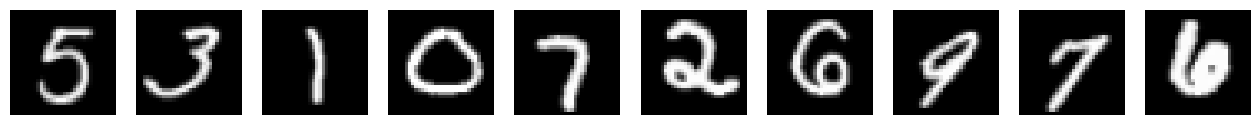

torch.Size([10, 3, 32, 32])
tensor([5, 3, 1, 0, 7, 2, 6, 9, 7, 6])


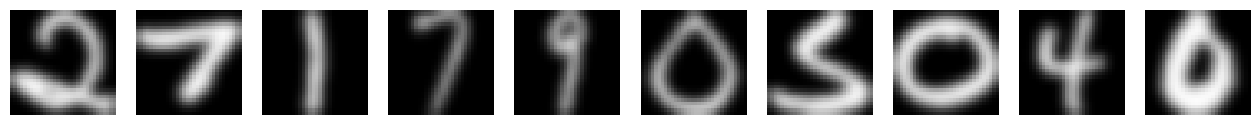

torch.Size([10, 3, 32, 32])
tensor([2, 7, 1, 7, 9, 0, 5, 0, 4, 0])


In [5]:
num_samples = 10

src_samples = next(iter(src_train))
tgt_samples = next(iter(tgt_train))

src_images, src_labels = src_samples[0][:num_samples], src_samples[1][:num_samples]
tgt_images, tgt_labels = tgt_samples[0][:num_samples], tgt_samples[1][:num_samples]

def plot_samples(samples, figsize=(16, 6)):
    fig, ax = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        ax[i].imshow(np.transpose(samples[i], (1, 2, 0)))
        ax[i].axis('off')
    plt.show()

plot_samples(src_images)
print(src_images.shape)
print(src_labels)

plot_samples(tgt_images)
print(tgt_images.shape)
print(tgt_labels)

## Source-only

### Build our model

In [6]:
model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

### Train the model

In [7]:
def evaluate(model, val_loader, loss_fn):
    val_loss = 0
    val_acc = 0

    training = model.training
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()
            val_loss += loss * x.shape[0]
            val_acc += n_correct
    model.train(training)
    
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    return (val_loss, val_acc)

def train(
    model,
    src_loader,
    tgt_loader,
    src_val_loader,
    tgt_val_loader,
    loss_fn,
    optimizer,
    mode='src-only',
    num_steps=20000,
    checkpoint=100,
):
    model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    tb_writer = SummaryWriter(log_dir=log_dir)

    for step in tqdm(range(num_steps)):
        try:
            src_x, src_y = next(src_loader_iter)
        except StopIteration:
            src_loader_iter = iter(src_loader)
            src_x, src_y = next(src_loader_iter)
        try:
            tgt_x, tgt_y = next(tgt_loader_iter)
        except StopIteration:
            tgt_loader_iter = iter(tgt_loader)
            tgt_x, tgt_y = next(tgt_loader_iter)
        
        src_x, src_y = src_x.to(device), src_y.to(device)
        tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

        if   mode == 'src-only':
            src_y_pred, _ = model(src_x)
            loss = loss_fn(src_y_pred, src_y)
        elif mode == 'tgt-only':
            tgt_y_pred, _ = model(tgt_x)
            loss = loss_fn(tgt_y_pred, tgt_y)
        elif mode == 'joint':
            src_y_pred, _ = model(src_x)
            tgt_y_pred, _ = model(tgt_x)
            loss = loss_fn(src_y_pred, src_y) + loss_fn(tgt_y_pred, tgt_y)
        else:
            raise ValueError(f'Invalid mode: {mode}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            src_val_loss, src_val_acc = evaluate(model, src_val_loader, loss_fn)
            tgt_val_loss, tgt_val_acc = evaluate(model, tgt_val_loader, loss_fn)

            train_stats += [[
                step,
                loss.item(),
            ]]
            val_stats += [[
                step,
                src_val_loss,
                src_val_acc,
                tgt_val_loss,
                tgt_val_acc,
            ]]

            tb_writer.add_scalar(mode+'/train/loss', loss.item(), step)
            tb_writer.add_scalar(mode+'/val/src_loss', src_val_loss, step)
            tb_writer.add_scalar(mode+'/val/src_acc', src_val_acc, step)
            tb_writer.add_scalar(mode+'/val/tgt_loss', tgt_val_loss, step)
            tb_writer.add_scalar(mode+'/val/tgt_acc', tgt_val_acc, step)

            if   mode == 'src-only':
                val_loss = src_val_loss
            elif mode == 'tgt-only':
                val_loss = tgt_val_loss
            elif mode == 'joint':
                val_loss = src_val_loss + tgt_val_loss
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), log_dir/f'{mode}_best_model.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [8]:
mode = 'src-only'
train_stats, val_stats = train(
    model,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    nn.CrossEntropyLoss(),
    torch.optim.Adam(model.parameters(), lr=1e-3),
    mode=mode,
    num_steps=2000,
    checkpoint=100,
)

100%|██████████| 2000/2000 [02:16<00:00, 14.66it/s]


### Learning curves

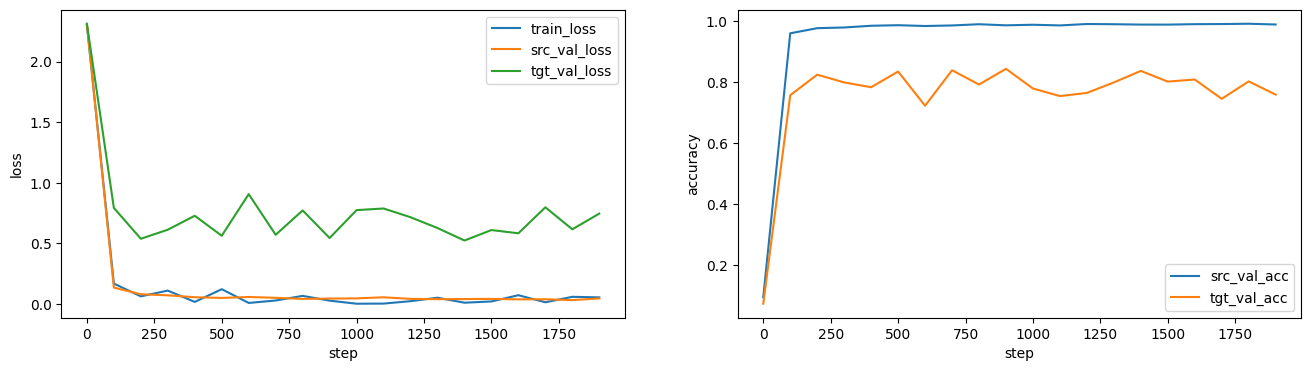

In [9]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_val_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_val_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

### Evaluate the best model

In [10]:
model.load_state_dict(torch.load(log_dir/f'{mode}_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print(f'{mode} model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

src-only model:
src_test -> loss: 0.0296, acc: 0.9909
tgt_test -> loss: 0.6670, acc: 0.7828


## Target-only

### Build our model

In [11]:
model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

### Train the model

In [12]:
mode = 'tgt-only'
train_stats, val_stats = train(
    model,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    nn.CrossEntropyLoss(),
    torch.optim.Adam(model.parameters(), lr=1e-3),
    mode=mode,
    num_steps=2000,
    checkpoint=100,
)

100%|██████████| 2000/2000 [02:19<00:00, 14.35it/s]


### Learning curves

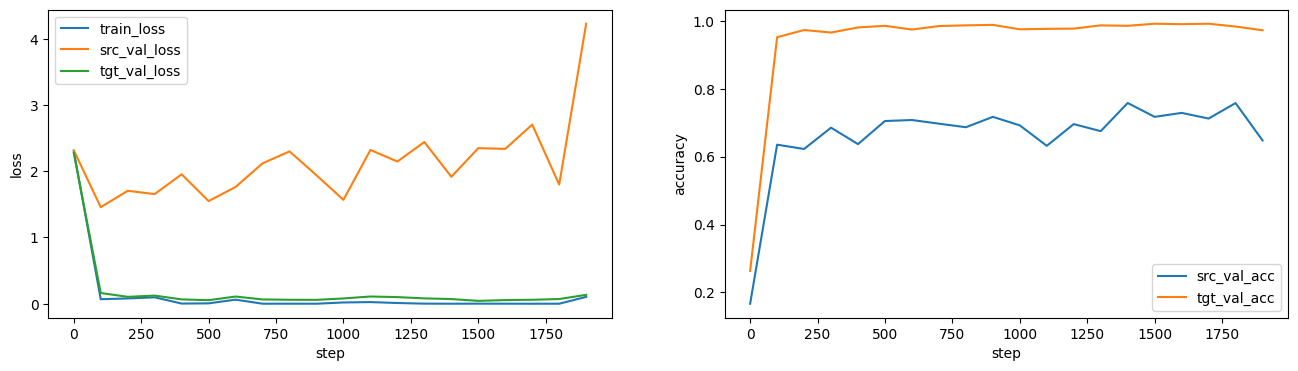

In [13]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_val_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_val_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

### Evaluate the best model

In [14]:
model.load_state_dict(torch.load(log_dir/f'{mode}_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print(f'{mode} model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

tgt-only model:
src_test -> loss: 2.3151, acc: 0.7232
tgt_test -> loss: 0.2232, acc: 0.9661


## Jointly (Source + Target)

### Build our model

In [15]:
model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

### Train the model

In [16]:
mode = 'joint'
train_stats, val_stats = train(
    model,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    nn.CrossEntropyLoss(),
    torch.optim.Adam(model.parameters(), lr=1e-3),
    mode=mode,
    num_steps=2000,
    checkpoint=100,
)

100%|██████████| 2000/2000 [02:19<00:00, 14.32it/s]


### Learning curves

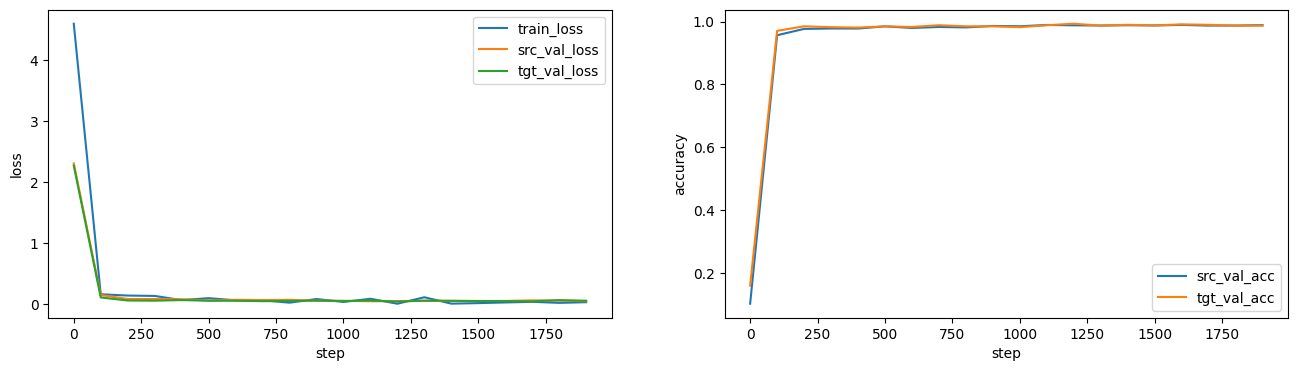

In [17]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_val_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_val_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

### Evaluate the best model

In [18]:
model.load_state_dict(torch.load(log_dir/f'{mode}_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print(f'{mode} model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

joint model:
src_test -> loss: 0.0347, acc: 0.9901
tgt_test -> loss: 0.1317, acc: 0.9686
